In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("BATS_AAPL.csv")

# Feature engineering (keep original rows)
df['MA10'] = df['close'].rolling(window=10).mean()
df['MA20'] = df['close'].rolling(window=20).mean()
df['Returns'] = df['close'].pct_change()
df['Volatility5'] = df['Returns'].rolling(window=5).std()

# Fill NaNs instead of dropping
# You can choose a method — here we forward-fill (ffill), then backward-fill (bfill) remaining ones
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Target: 1 if next close > current close, else 0
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# For the last row (where shift created NaN), we’ll just copy the second-last label (or 0 as default)
if df['target'].isna().sum() > 0:
    df['target'].fillna(method='ffill', inplace=True)
    df['target'].fillna(0, inplace=True)  # fallback in case it's still NaN

# Define the features to be scaled
feature_cols = ['open', 'high', 'low', 'close', 'Volume',
                'Basis', 'Upper', 'Lower', 'EMA', 'RSI',
                'MACD', 'Signal', 'Histogram', 'MA10',
                'MA20', 'Volatility5']

# Scale features (all rows retained)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# Target as numpy array
y = df['target'].astype(int).values

# Confirm shape
print("Final shape:", X_scaled.shape, "Target length:", len(y))


Final shape: (21276, 16) Target length: 21276


<ipython-input-15-853b395f1153>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-15-853b395f1153>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [16]:
import numpy as np

# Assume df and X_scaled have already been prepared with all rows kept (no dropping)
# And df['target'] was already created with shift(-1) and .fillna() earlier

# Feature array and target
X = X_scaled
y = df['target'].astype(int).values

# Prepare LSTM sequences
L = 50  # sequence/window length
X_seq, y_seq = [], []

for i in range(L, len(X)):
    X_seq.append(X[i-L:i])    # sequence of L timesteps
    y_seq.append(y[i])        # target: movement after the sequence

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("Sequence data shape:", X_seq.shape)
print("Target shape:", y_seq.shape)


Sequence data shape: (21226, 50, 16)
Target shape: (21226,)


In [17]:
# Train-test split (chronologically)
train_size = int(0.8 * len(X_seq))
X_train_full, X_test = X_seq[:train_size], X_seq[train_size:]
y_train_full, y_test = y_seq[:train_size], y_seq[train_size:]

# Further split training data into train/validation for tuning
val_size = int(0.1 * len(X_train_full))
X_train = X_train_full[:-val_size]
y_train = y_train_full[:-val_size]
X_val = X_train_full[-val_size:]
y_val = y_train_full[-val_size:]
print("Train sequences:", X_train.shape[0], "Validation sequences:", X_val.shape[0], "Test sequences:", X_test.shape[0])


Train sequences: 15282 Validation sequences: 1698 Test sequences: 4246


In [18]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt  # Keras Tuner

def build_model(hp):
    model = keras.Sequential()
    # Hyperparameters to tune:
    num_layers = hp.Int('layers', 1, 2)  # number of LSTM layers (1 or 2)
    units = hp.Int('units', min_value=32, max_value=128, step=32)  # LSTM units
    dropout_rate = hp.Float('dropout', 0.0, 0.5, step=0.1)         # dropout rate
    learning_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')     # learning rate (log scale)

    # First LSTM layer
    model.add(layers.LSTM(units, return_sequences=(num_layers==2),
                           input_shape=(L, X_train.shape[2])))
    model.add(layers.Dropout(dropout_rate))
    # Optional second LSTM layer
    if num_layers == 2:
        model.add(layers.LSTM(units))
        model.add(layers.Dropout(dropout_rate))
    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


<ipython-input-19-152e27c629e0>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt  # Keras Tuner


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband_logs',
    project_name='lstm_stock_tuning'
)

# EarlyStopping for each trial to prevent over-training any configuration
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,  # upper bound of epochs for each trial
             callbacks=[early_stop],
             verbose=1)


Trial 90 Complete [00h 01m 56s]
val_accuracy: 0.5123674869537354

Best val_accuracy So Far: 0.517667829990387
Total elapsed time: 03h 22m 00s


In [21]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"Layers: {best_hps.get('layers')}")
print(f"Units: {best_hps.get('units')}")
print(f"Dropout: {best_hps.get('dropout'):.2f}")
print(f"Learning Rate: {best_hps.get('lr'):.5f}")
print(f"Batch Size: {best_hps.get('batch_size') if 'batch_size' in best_hps.values else 'default'}")

# Build the model with best hyperparameters and train on full training data
best_model = build_model(best_hps)


Best hyperparameters found:
Layers: 2
Units: 96
Dropout: 0.30
Learning Rate: 0.00027
Batch Size: default


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Combine train and validation sets
X_train_combined = np.concatenate([X_train, X_val])
y_train_combined = np.concatenate([y_train, y_val])

# Fix: Retrieve batch_size safely from best_hps
if 'batch_size' in best_hps.values:
    batch_size = best_hps.get('batch_size')
else:
    batch_size = 64  # fallback default if not tuned

# EarlyStopping callback
final_es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the final model
history = best_model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),  # optional: keeps track of val performance
    epochs=100,
    batch_size=batch_size,
    callbacks=[final_es],
    verbose=2
)


Epoch 1/100
266/266 - 48s - 179ms/step - accuracy: 0.5060 - loss: 0.6942 - val_accuracy: 0.4988 - val_loss: 0.6942
Epoch 2/100
266/266 - 36s - 137ms/step - accuracy: 0.5074 - loss: 0.6934 - val_accuracy: 0.5024 - val_loss: 0.6931
Epoch 3/100
266/266 - 41s - 155ms/step - accuracy: 0.5043 - loss: 0.6934 - val_accuracy: 0.5035 - val_loss: 0.6931
Epoch 4/100
266/266 - 37s - 138ms/step - accuracy: 0.5098 - loss: 0.6932 - val_accuracy: 0.5065 - val_loss: 0.6930
Epoch 5/100
266/266 - 41s - 154ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.5012 - val_loss: 0.6931
Epoch 6/100
266/266 - 41s - 153ms/step - accuracy: 0.5063 - loss: 0.6934 - val_accuracy: 0.4988 - val_loss: 0.6932
Epoch 7/100
266/266 - 36s - 136ms/step - accuracy: 0.5050 - loss: 0.6934 - val_accuracy: 0.5088 - val_loss: 0.6930
Epoch 8/100
266/266 - 41s - 153ms/step - accuracy: 0.5075 - loss: 0.6931 - val_accuracy: 0.4988 - val_loss: 0.6940
Epoch 9/100
266/266 - 41s - 153ms/step - accuracy: 0.5085 - loss: 0.6931 - val_a

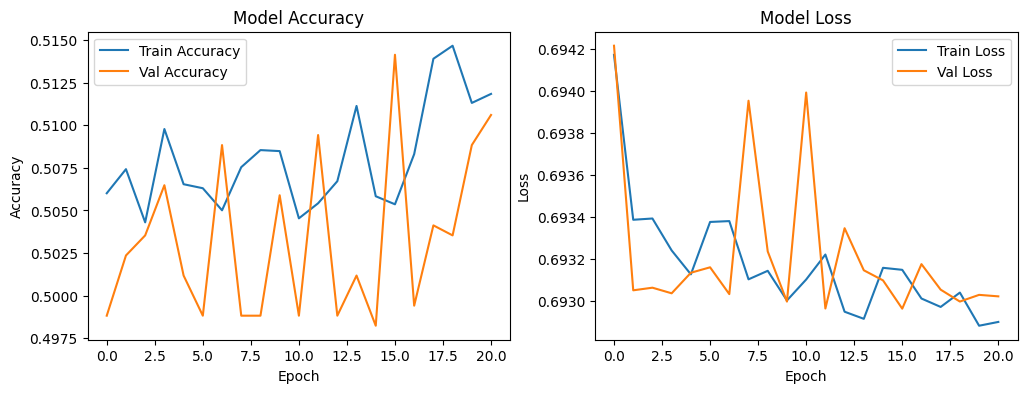

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.show()


In [25]:
# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.3f}")

# Predictions and confusion matrix
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()  # classify prob >=0.5 as 1

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=['Down/No-Rise','Up'])
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)


Test Accuracy: 0.502
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Confusion Matrix:
 [[1791  335]
 [1780  340]]
Classification Report:
               precision    recall  f1-score   support

Down/No-Rise       0.50      0.84      0.63      2126
          Up       0.50      0.16      0.24      2120

    accuracy                           0.50      4246
   macro avg       0.50      0.50      0.44      4246
weighted avg       0.50      0.50      0.44      4246

